In [43]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

# Table of content
1. Define functions, load data
    - Import `interactive` maps module
    - Define functions for calculating `distance` on Earth
    - Define function for drawing `the big heatmap` of correlations
    - Define a help function for drawing `quantiles lines` in grouped plots
    - Load DataFrames for `apartaments` and `metro` 
2. Prepare data
    - Add `price` to `rental price` in order to get `real price`
    - Remove `Nan` values in `geographic coordinates`.
    - Find `distance` to nearest metro station for all valid houses
    - Find `distance` to city center (`PKiN`) for all valid houses
    - Remove distance `outliers`
    - Read `districts'` shape data
    - Assign `districts` to all houses 
3. Analyse dataset
    - Price `violinplots` for each district
    - `Median price` for each district (**interactive map**) 
    - Correlations in `data`
    - Various interesting `correlated plots`
4. Prediction
    - Import libraries
    - Prepare input (`x`) and target (`y`) variables 
    - Split to `training` and `test` set, then scale values
    - Learn using `support vector mashines (SVM)` with `rbf` kernel
    - Calculate error on `train set`
    - Calculate error on `test set`
    - Analyse of `error` in regression approach (**unique method**)
    - Test on some `hand-typed` data 

# 1. Define functions, load data

## 1.1. Import interactive maps module

In [44]:
import geopandas as gpd
import folium
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster

In [45]:
# Function for displaying the map

def embed_map(m, file_name):
    from IPython.display import IFrame
    m.save(file_name)
    return IFrame(file_name, width='100%', height='500px')

## 1.2. Define functions for calculating distance on Earth

In [46]:
# Using geopy
import geopy.distance

def dist(a, b):
    return geopy.distance.geodesic((a.x, a.y), (b.x, b.y)).km

In [47]:
# Using geopandas
def dist_2(a, b):
    a = gpd.GeoSeries(Point(a.y, a.x), crs=({"init":"epsg:4326"})).to_crs(epsg=3310)
    b = gpd.GeoSeries(Point(b.y, b.x), crs=({"init":"epsg:4326"})).to_crs(epsg=3310)
    return a.distance(b) / 1000

## 1.3. Define a function for drawing the big heatmap of correlations
source: https://towardsdatascience.com/better-heatmaps-and-correlation-matrix-plots-in-python-41445d0f2bec

In [48]:
# Define global variables for heatmap block
n_colors = 256 # Use 256 colors for the diverging color palette
palette = sns.diverging_palette(20, 220, n=n_colors) # Create the palette
color_min, color_max = [-1, 1] # Range of values that will be mapped to the palette, i.e. min and max possible correlation


def value_to_color(val):
    val_position = float((val - color_min)) / (color_max - color_min) # position of value in the input range, relative to the length of the input range
    ind = int(val_position * (n_colors - 1)) # target index in the color palette
    return palette[ind]


def heatmap(x, y, size, color):
    fig, ax = plt.subplots()
    fig.set_figheight(12)
    fig.set_figwidth(12)
    
    # Mapping from column names to integer coordinates
    x_labels = [v for v in sorted(x.unique())]
    y_labels = [v for v in sorted(y.unique())]
    x_to_num = {p[1]:p[0] for p in enumerate(x_labels)} 
    y_to_num = {p[1]:p[0] for p in enumerate(y_labels)} 
    
    size_scale = 500
    ax.scatter(
        x=x.map(x_to_num), # Use mapping for x
        y=y.map(y_to_num), # Use mapping for y
        s=size * size_scale, # Vector of square sizes, proportional to size parameter
        c=color.apply(value_to_color), # Vector of square color values, mapped to color palette
        marker='s' # Use square as scatterplot marker
    )
    
    # Show column labels on the axes
    ax.set_xticks([x_to_num[v] for v in x_labels])
    ax.set_xticklabels(x_labels, rotation=45, horizontalalignment='right')
    ax.set_yticks([y_to_num[v] for v in y_labels])
    ax.set_yticklabels(y_labels)

    ax.grid(False, 'major')
    ax.grid(True, 'minor')
    ax.set_xticks([t + 0.5 for t in ax.get_xticks()], minor=True)
    ax.set_yticks([t + 0.5 for t in ax.get_yticks()], minor=True)


def display_heatmap(df):
    
    corr = df.corr()

    corr = pd.melt(corr.reset_index(), id_vars='index') # Unpivot the dataframe, so we can get pair of arrays for x and y
    corr.columns = ['x', 'y', 'value']
    heatmap(
        x=corr['x'],
        y=corr['y'],
        # Exaggerate colors to stress if there is ANY correlation, even little
        size=corr['value'].abs().apply(lambda x: min(1, 3*x)), 
        color=-corr['value'].apply(lambda x: max(-1, min(1, 3*x)))
    )

## 1.4. Define a help function for drawing quantiles lines in grouped plots.
Lines are connecting neightbouring `0.25, 0.50, 0.75 quantiles points`, if data is grouped by `horizontal group`.

- `sort = True` sorts `horizontal group` values by `vertical group`'s median

- `as_index = True` uses `horizontal group`'s labels while plotting, otherwise `ordinal order` is used (so first group is treated as `0`, second group as `1`, ... while plotting)

In [49]:
def quantile_lines(df, horizontal_group, vertical_group, as_index=False, sort=False):
    
    df = df.groupby(horizontal_group, as_index=as_index).describe()[vertical_group][['25%', '50%', '75%']]
    if sort:
        df = df.sort_values(by='50%', ascending=False)
    
    x = df.index
    y1, y2, y3 = df['25%'], df['50%'], df['75%']
    
    plt.plot(x, y2, linewidth=4, color='k')
    plt.plot(x, y1, linewidth=2, color='k', linestyle='dashed')
    plt.plot(x, y3, linewidth=2, color='k', linestyle='dashed')
    plt.fill_between(x, y1, y3, color='gray', alpha='0.5')

## 1.5. Load DataFrames for `apartaments` and `metro`

In [50]:
apartaments = pd.read_csv("apartaments.csv")
metro = pd.read_csv("metro.csv")

# 2. Prepare data

## 2.1. Add `price` to `rental price` in order to get `real price`
Then insert a second column indicating `price per square meter` using `real price`.

In [51]:
# Function to check if value is Nan or not
def notNan(a):
    return a == a

In [52]:
def real_price(row):
    if notNan(row['Czynsz - dodatkowo']):
        return int(row['Cena']) + int(row['Czynsz - dodatkowo'])
    else:
        return int(row['Cena'])

In [53]:
if 'Cena rzeczywista' in apartaments or not 'Cena' in apartaments:
    print("Reloading apartamens.csv file")
    apartaments = pd.read_csv("apartaments.csv")
    
apartaments.insert(1, "Cena rzeczywista", apartaments.apply(real_price, axis=1))
apartaments.insert(2, "Cena za metr", round(apartaments['Cena rzeczywista'] / apartaments['Powierzchnia'], 2))

## 2.2. Remove `Nan` values in `geographic coordinates`.
And remove biggest outliers

In [54]:
apartaments = apartaments[notNan(apartaments['φ'])]
apartaments = apartaments[apartaments['Cena rzeczywista'] <= 50000]
apartaments = apartaments[apartaments['Powierzchnia'] >= 10]

## 2.3. Find distance to nearest metro station for all valid houses
*This is the most time consuming part of this notebook as there is alot of metro stations and all have to be checked with all houses.*

In [55]:
nearest_metro_dist = []
nearest_metro_name = []

for idx, house in apartaments.iterrows():
    if notNan(house['φ']):
        list_ = [dist(Point(house['φ'], house['λ']), Point(station['φ'], station['λ']))
                 for jdx, station in metro.iterrows()]
        nearest_metro_dist.append(round(min(list_), 4))
        nearest_metro_name.append(metro.iloc[np.argmin(list_)]['Nazwa'])
    else:
        nearest_metro_dist.append(np.nan)
        nearest_metro_name.append(np.nan)
        
        
if "Odległość od najbliższej stacji metra" in apartaments:
    apartaments = apartaments.drop('Odległość od najbliższej stacji metra', axis=1)
apartaments.insert(apartaments.shape[1], "Odległość od najbliższej stacji metra", nearest_metro_dist)

if "Najbliższa stacja metra" in apartaments:
    apartaments = apartaments.drop('Najbliższa stacja metra', axis=1)
apartaments.insert(apartaments.shape[1], "Najbliższa stacja metra", nearest_metro_name)

## 2.4. Find distance to city center (`Pałac Kultury`) for all valid houses

In [56]:
city_center_dist = []

for idx, house in apartaments.iterrows():
    if notNan(house['φ']):
        city_center_dist.append(round(dist(Point(house['φ'], house['λ']), Point(52.2323, 21.0000)), 4))
    else:
        city_center_dist.append(np.nan)
        
        
if "Odległość od centrum" in apartaments:
    apartaments = apartaments.drop("Odległość od centrum", axis=1) 
apartaments.insert(apartaments.shape[1], "Odległość od centrum", city_center_dist) 

## 2.5. Remove distance outliers

In [57]:
apartaments = apartaments[apartaments['Odległość od centrum'] <= 40]

## 2.6. Read districts' shape data

In [58]:
geo = gpd.read_file("districts/warszawa_dzielnice.shp").to_crs({'init': 'epsg:4326'})
geo = geo.drop(0).reset_index().drop(columns=['index', 'cartodb_id'])

/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


## 2.7. Assign districts to all houses

In [59]:
def assign_district(row):
    point = Point(row['λ'], row['φ'])
    if notNan(row['φ']):
        return np.argmax([polygon.contains(point) for polygon in geo['geometry']])
    else:
        return np.nan

apartaments['Numer dzielnicy'] = apartaments.apply(assign_district, axis=1)
apartaments['Nazwa dzielnicy'] = apartaments['Numer dzielnicy'].apply(
    lambda x: geo.iloc[int(x)]['name'] if notNan(x) else np.nan)

# 3. Analyse dataset

In [60]:
apartaments.head()

,Cena,Cena rzeczywista,Cena za metr,Kaucja,Powierzchnia,Liczba pokoi,Rodzaj zabudowy,Piętro,Okna,Ogrzewanie,...,Czynsz - dodatkowo,Liczba pięter,Materiał budynku,Rok budowy,Czas dojazdu do centrum,Odległość od najbliższej stacji metra,Najbliższa stacja metra,Odległość od centrum,Numer dzielnicy,Nazwa dzielnicy
0,2400,2400,50.00,2400.0,48.0,3,blok,2,plastikowe,miejskie,...,NaN,NaN,NaN,NaN,25.0,2.3963,Metro Stadion Narodowy,4.5333,7,Praga Południe
1,2400,2900,64.44,3000.0,45.0,2,apartamentowiec,2,plastikowe,miejskie,...,500.0,5.0,cegła,2014.0,36.0,0.2076,Metro Młociny,7.9005,5,Bielany
2,2600,2600,65.00,NaN,40.0,2,apartamentowiec,4,plastikowe,miejskie,...,NaN,6.0,pustak,2018.0,31.0,2.1875,Metro Wierzbno,4.7630,6,Mokotów
3,2300,2700,50.00,2500.0,54.0,2,blok,1,plastikowe,miejskie,...,400.0,5.0,NaN,2007.0,46.0,1.3607,Metro Trocka,7.2078,10,Targówek
4,2950,3300,61.11,NaN,54.0,3,blok,3,drewniane,miejskie,...,350.0,4.0,cegła,2016.0,47.0,2.3051,Metro Natolin,10.4301,15,Wilanów


## 3.1. Price violinplots for each district

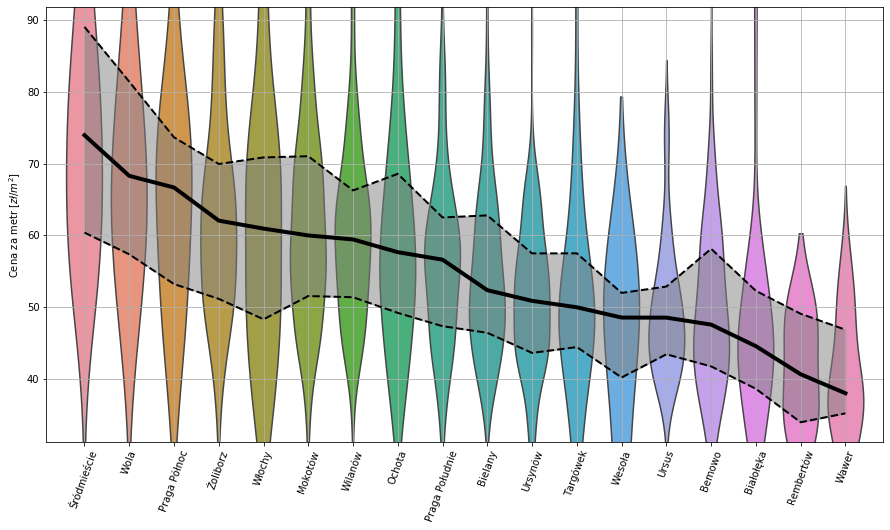

In [61]:
df = apartaments.copy()

# Filter by removing districts with fewer than 5 datapoints
df_ = df.groupby('Nazwa dzielnicy')['Cena za metr'].describe()['count']
df = df[df['Nazwa dzielnicy'].isin(df_[df_ >= 5].index.tolist())]

# Create order in which districts will be shown
order = df.groupby('Nazwa dzielnicy')['Cena za metr'].describe()['50%'].sort_values(ascending=False)

# Draw violinplots and quantile lines
plt.figure(figsize=(15,8))
sns.violinplot(data=df, x='Nazwa dzielnicy', y='Cena za metr', order=order.index, scale='width', inner=None)#'quartile')
quantile_lines(df, 'Nazwa dzielnicy', 'Cena za metr', as_index=True, sort=True)

plt.xticks(rotation=70)
plt.ylabel('Cena za metr [$zł/m^2$]')
plt.xlabel('')
plt.grid()

*All violinplots are ordered by median price.*
## Comment:

---
---
---

## 3.2. Show median price for each district
Use `df` DataFrame from previous section "`Price violinplots for each district`", so it's properly filtered.

- Only apartaments fullfilling conditions from previous section are shown

- `Black color` means there was not enough data to calculate median price `meaningfully`

In [62]:
plot_dict = df.groupby('Numer dzielnicy')['Cena za metr'].describe()['50%']
plot_dict.index = [str(i) for i in plot_dict.index]

In [63]:
# Create a base map
m_1 = folium.Map(location=[52.2323,21.0000], tiles='cartodbpositron', zoom_start=10)

# Add apartaments to the map
mc = MarkerCluster()
for idx, house in df.iterrows():
    if notNan(house['φ']):
        mc.add_child(Marker([house['φ'], house['λ']], popup=str(house['Cena za metr']) + "zł/m^2"))
m_1.add_child(mc)

# Add districts coloured by median price to the map
Choropleth(geo_data=geo.__geo_interface__, 
           data=plot_dict,
           key_on="feature.id", 
           fill_color='YlGnBu', 
           legend_name='Mediana cen [zł/m^2]',
          ).add_to(m_1)

# Display the map
embed_map(m_1, 'maps/m_1.html')

## 3.3. Correlations in data
Restrict `real price` $ \le $ 20 000 zł

,Cena rzeczywista,Cena za metr,Powierzchnia,Liczba pokoi,Piętro,φ,λ,Liczba pięter,Rok budowy,Czas dojazdu do centrum,Odległość od najbliższej stacji metra,Odległość od centrum
Cena rzeczywista,1.000000,0.507076,0.817904,0.624450,0.078839,-0.091180,0.109139,0.049093,0.039946,-0.259807,-0.222424,-0.260856
Cena za metr,0.507076,1.000000,-0.019296,-0.104250,0.123810,0.058169,-0.045797,0.117840,0.028950,-0.457059,-0.314049,-0.454979
Powierzchnia,0.817904,-0.019296,1.000000,0.823195,0.031639,-0.163706,0.167747,-0.013784,0.020190,-0.040850,-0.085067,-0.041000
Liczba pokoi,0.624450,-0.104250,0.823195,1.000000,0.034833,-0.166756,0.153114,-0.024197,0.024605,0.015848,-0.036256,0.012846
Piętro,0.078839,0.123810,0.031639,0.034833,1.000000,0.019352,-0.108563,0.065347,0.172154,-0.191402,-0.181570,-0.190755
φ,-0.091180,0.058169,-0.163706,-0.166756,0.019352,1.000000,-0.290893,0.033053,-0.075417,-0.151910,0.029116,-0.272546
λ,0.109139,-0.045797,0.167747,0.153114,-0.108563,-0.290893,1.000000,-0.034607,-0.058016,0.140311,0.058540,0.291233
Liczba pięter,0.049093,0.117840,-0.013784,-0.024197,0.065347,0.033053,-0.034607,1.000000,0.051587,-0.057442,-0.043195,-0.058258
Rok budowy,0.039946,0.028950,0.020190,0.024605,0.172154,-0.075417,-0.058016,0.051587,1.000000,0.279638,0.196261,0.258603
Czas dojazdu do centrum,-0.259807,-0.457059,-0.040850,0.015848,-0.191402,-0.151910,0.140311,-0.057442,0.279638,1.000000,0.579516,0.876848


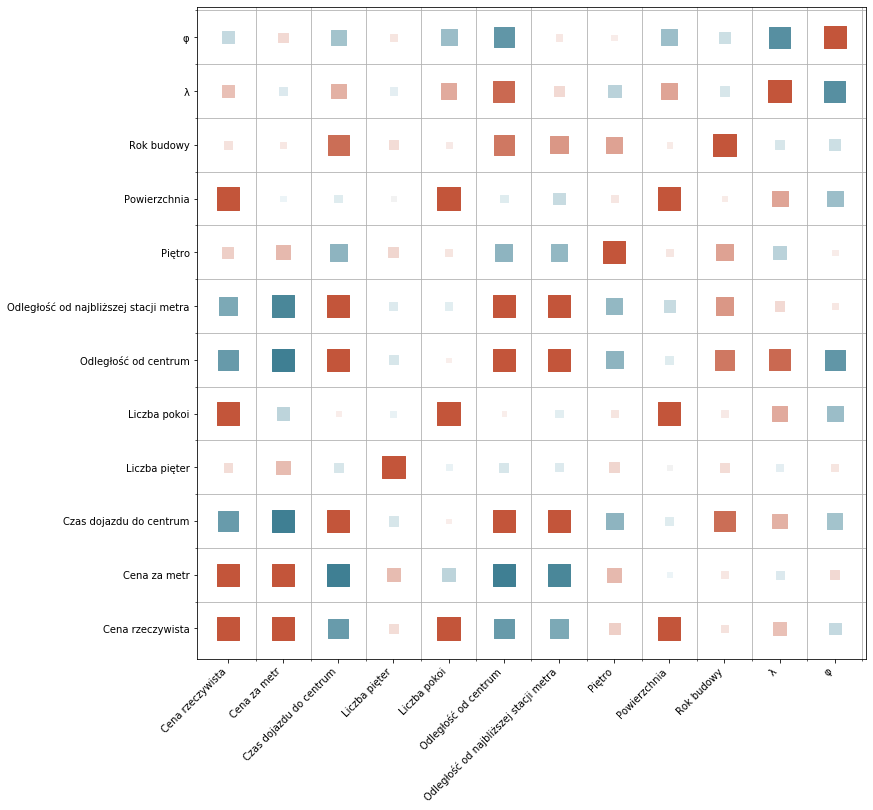

In [64]:
df = apartaments.copy().drop(columns=['Cena', 'Czynsz - dodatkowo', 'Kaucja', 'Numer dzielnicy'])
df = df[df['Cena rzeczywista'] <= 20000]  # Filter prices

# Convert columns 'Piętro' and 'Liczba pokoi' to numeric values
dict_ = dict({"parter" : 0, "poddasze" : np.nan, "> 10" : np.nan, "więcej niż 10" : np.nan})
df = df.replace({"Piętro" : dict_})
df = df.replace({"Liczba pokoi" : dict_})
df['Piętro'] = df['Piętro'].astype('float')
df['Liczba pokoi'] = df['Liczba pokoi'].astype('float')

# Show table of correlations and the big heatmap
display(df.corr())
display_heatmap(df)

## 3.5. Various interesting correlated plots

3.5.1. `Area`/`Number of rooms`/`Floor number` vs `Price`

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]),
 <a list of 28 Text xticklabel objects>)

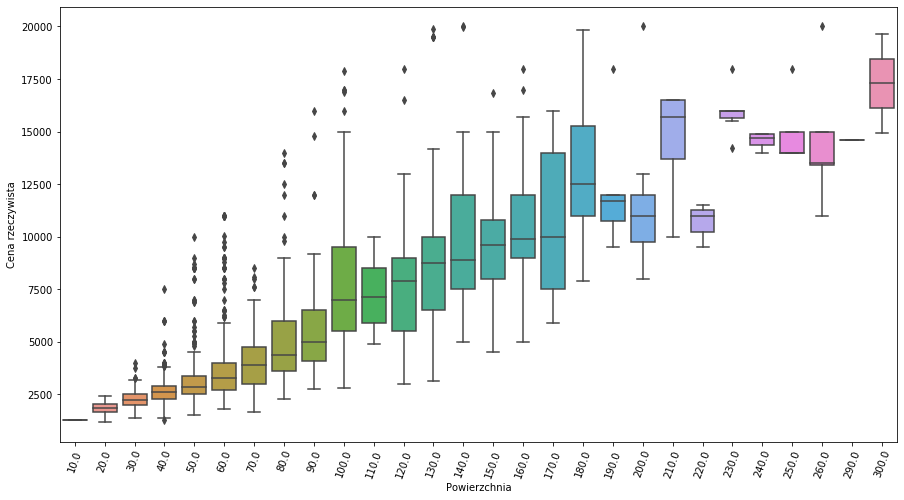

In [65]:
plt.figure(figsize=(15,8))
sns.boxplot('Powierzchnia', 'Cena rzeczywista', data=df.apply
           (lambda x: round(x/10)*10 if x.name == 'Powierzchnia' else x))
plt.xticks(rotation=70)

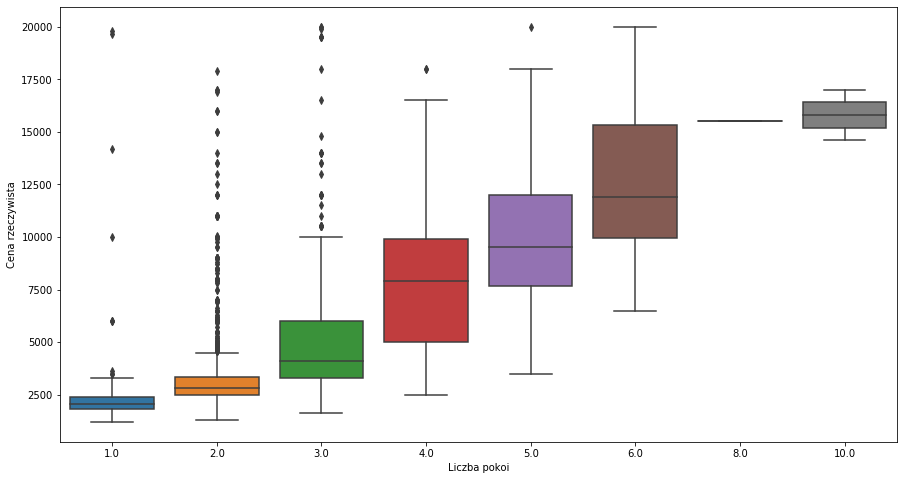

In [66]:
plt.figure(figsize=(15,8))
sns.boxplot('Liczba pokoi', 'Cena rzeczywista', data=df)

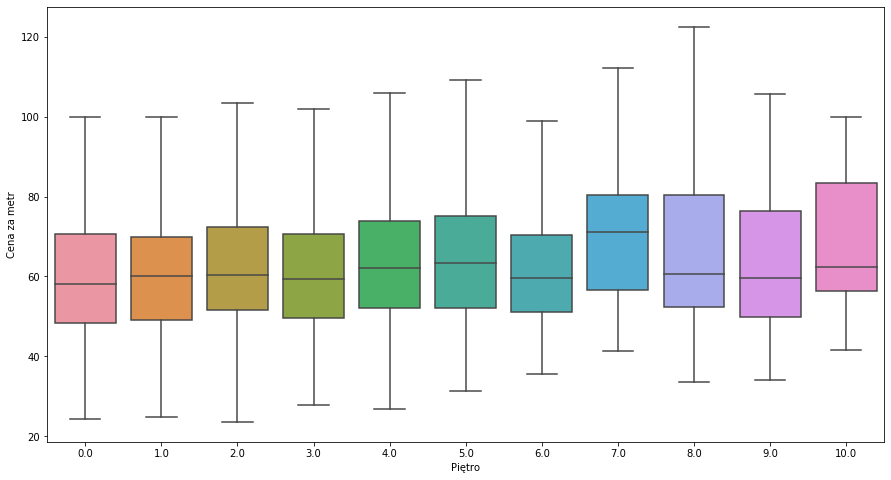

In [67]:
plt.figure(figsize=(15,8))
sns.boxplot('Piętro', 'Cena za metr', data=df, showfliers=False)

3.5.2. `Distance from city center`/`Distance from metro`/`Time travel to city center` vs `Price`

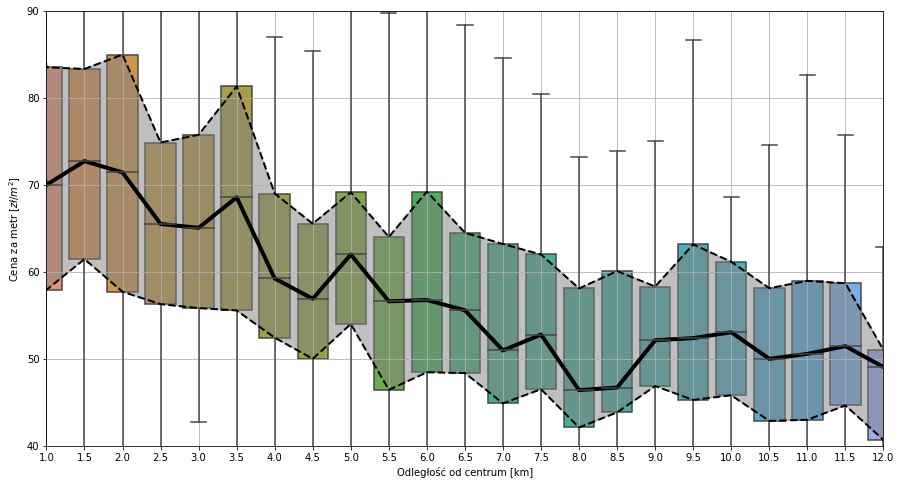

In [68]:
bin_size = 0.5
plt.figure(figsize=(15,8))
df_ = df.copy()
df_ = df_.apply(lambda x: round(x/bin_size)*bin_size if x.name == 'Odległość od centrum' else x)

sns.boxplot(x='Odległość od centrum', y='Cena za metr', data=df_, showfliers=False)#, scale='width', inner='quartile')
quantile_lines(df_, 'Odległość od centrum', 'Cena za metr', as_index=False)

plt.xlabel('Odległość od centrum [km]')
plt.ylabel('Cena za metr [$zł/m^2$]')
plt.ylim(40, 90)
plt.xlim(1/bin_size, 12/bin_size)
plt.grid()

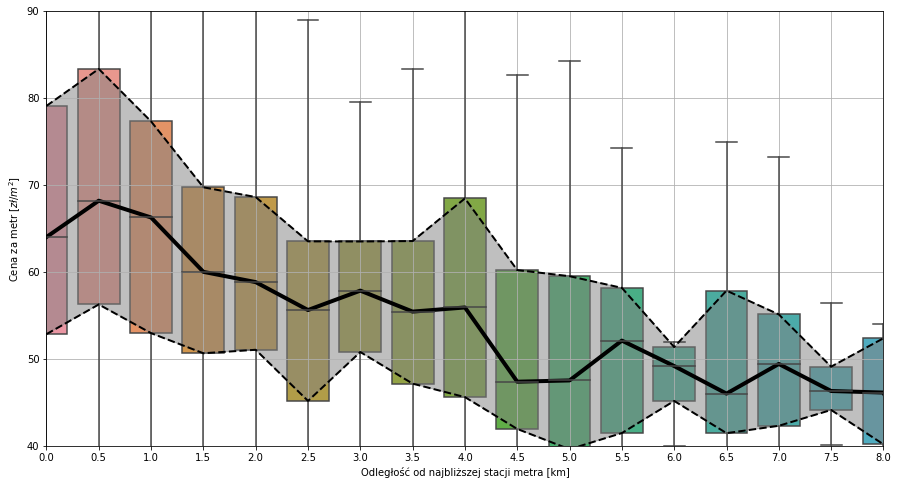

In [69]:
bin_size = 0.5
plt.figure(figsize=(15,8))
df_ = df.copy()
df_ = df_.apply(lambda x: round(x/bin_size)*bin_size if x.name == 'Odległość od najbliższej stacji metra' else x)

sns.boxplot('Odległość od najbliższej stacji metra', 'Cena za metr', data=df_, showfliers=False)#, scale='width', inner='quartile')
quantile_lines(df_, 'Odległość od najbliższej stacji metra', 'Cena za metr', as_index=False)

plt.xlabel('Odległość od najbliższej stacji metra [km]')
plt.ylabel('Cena za metr [$zł/m^2$]')
plt.xlim(0/bin_size, 8/bin_size)
plt.ylim(40, 90)
plt.grid()

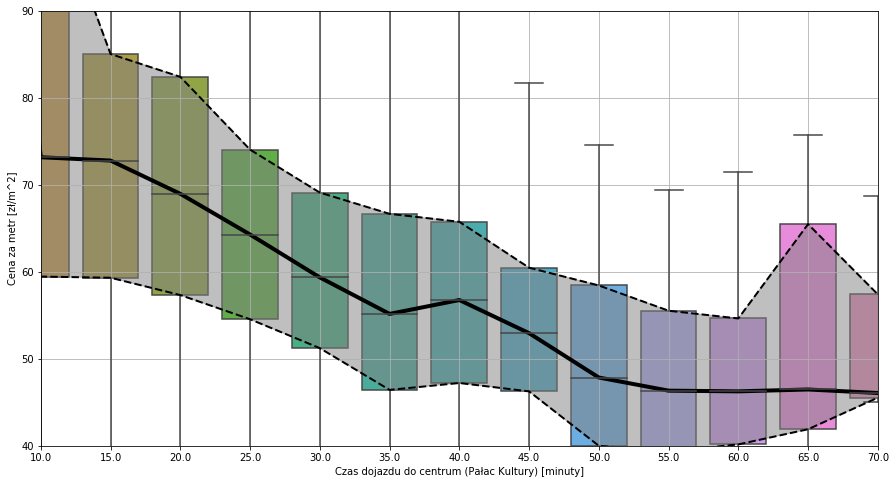

In [70]:
bin_size = 5
plt.figure(figsize=(15,8))
df_ = df.copy()
df_ = df_.apply(lambda x: round(x/bin_size)*bin_size if x.name == 'Czas dojazdu do centrum' else x)

sns.boxplot('Czas dojazdu do centrum', 'Cena za metr', data=df_, showfliers=False)#, scale='width', inner='quartile')
quantile_lines(df_, 'Czas dojazdu do centrum', 'Cena za metr', as_index=False)

plt.xlabel('Czas dojazdu do centrum (Pałac Kultury) [minuty]')
plt.ylabel('Cena za metr [zł/m^2]')
plt.xlim(10/bin_size, 70/bin_size)
plt.ylim(40, 90)
plt.grid()

3.5.3. `Year of building` vs `Distance from city center`/`Price`

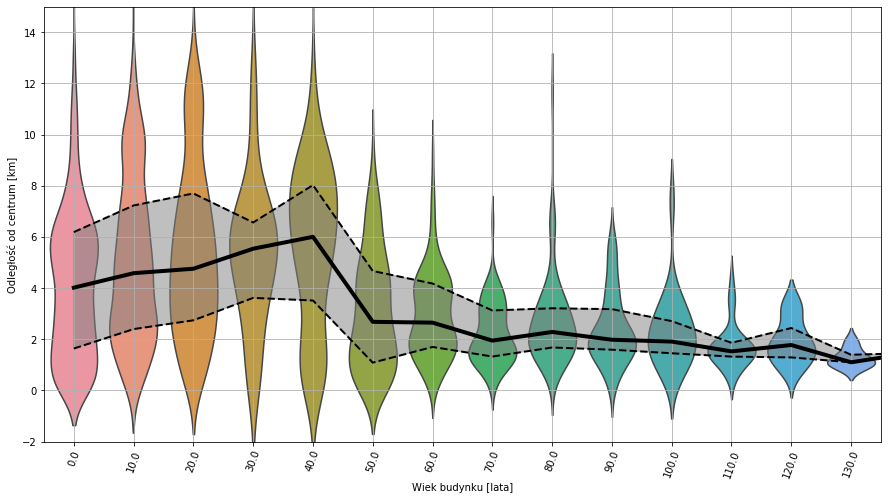

In [71]:
bin_size = 10
plt.figure(figsize=(15,8))

# Calculate `Age of building` from `Year of build` and create bins of size of `10 years`
df_ = apartaments.apply(lambda x: round((2019-x)/bin_size)*bin_size if x.name == 'Rok budowy' else x)

# Draw violinplots for all bins
sns.violinplot(x='Rok budowy', y='Odległość od centrum', data=df_, showfliers=False, scale='width', inner=None)#'quartile')
quantile_lines(df_, 'Rok budowy', 'Odległość od centrum')

plt.xticks(rotation=70)
plt.xlabel('Wiek budynku [lata]')
plt.ylabel('Odległość od centrum [km]')
plt.ylim(-2, 15)
plt.xlim(-5/bin_size, 135/bin_size)
plt.grid()

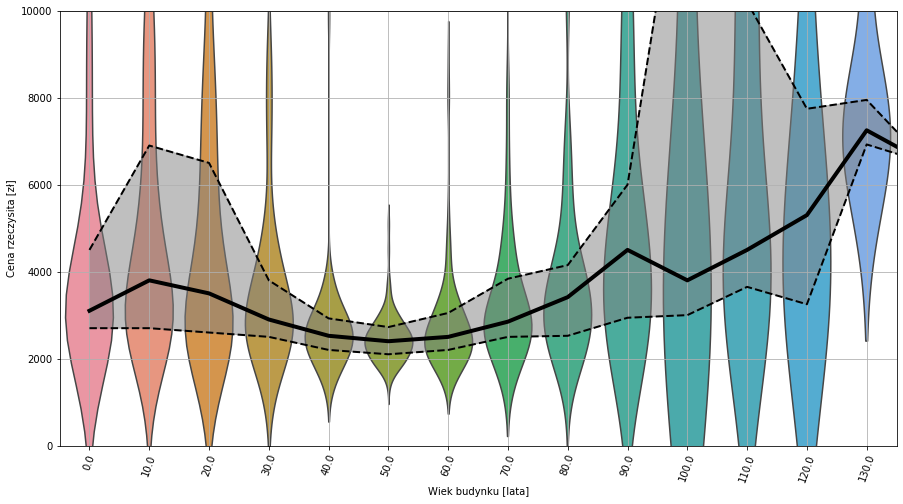

In [72]:
bin_size = 10
plt.figure(figsize=(15,8))

df_ = apartaments.apply(lambda x: round((2019-x)/bin_size)*bin_size if x.name == 'Rok budowy' else x)

sns.violinplot('Rok budowy', 'Cena rzeczywista', data=df_, showfliers=False, scale='width', inner=None)#'quartile')         
#sns.stripplot('Rok budowy', 'Cena rzeczywista', data=df_, color='k')
quantile_lines(df_, 'Rok budowy', 'Cena rzeczywista')
               
plt.xticks(rotation=70)
plt.xlabel('Wiek budynku [lata]')
plt.ylabel('Cena rzeczysita [zł]')
plt.ylim(0, 10000)
plt.xlim(-5/bin_size, 135/bin_size)
plt.grid()

## Comments:

1._Area, rooms, distance and time
- `price` and `area of house` relation is `strongly linear`
- `price` and `number of rooms` relation is `strongly linear`
- there is `no relation` between `price` and `floor number`
- there is `some correlation` between `price per square meter` and `distance to city center`, aswell as between `nearest metro station location` and `price per square meter`. 

2._Age of buildings

- analysing `building's age` and `distance from city center` leads to conclusion, that Warsaw was destroyed in WWII and is being rebuilded starting from city center to `outside direction`
- from `price` vs `building's age` plot we see that the minimum price is for `age = 50 years` (buildings build at year 1970). New buldings aswell as very old buldings are `worth the most`.

# 4. Prediction
An approach to predict `real price` of a property basing on its `area`, `number of rooms`, `location`, `year of build` and `travel time`.

Restrict `real price` $ \le $ 20 000 zł to avoid outliers

## 4.1. Import libraries

In [73]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import r2_score

## 4.2. Prepare input (`x`) and target (`y`) variables
Restrict `prices` to $\le$ 20.000 zł

In [74]:
df_ = apartaments.copy()
df_ = df_[df_['Cena rzeczywista'] <= 20000] # Filter prices

# Convert columns 'Piętro' and 'Liczba pokoi' to numeric values
dict_ = dict({"parter" : 0, "poddasze" : np.nan, "> 10" : np.nan, "więcej niż 10" : np.nan})
df_ = df_.replace({"Piętro" : dict_})
df_ = df_.replace({"Liczba pokoi" : dict_})
df_['Piętro'] = df_['Piętro'].astype('float')
df_['Liczba pokoi'] = df_['Liczba pokoi'].astype('float')


# Convert other string values to integers
def Encode(df_):
    for column in df_.columns[df_.columns.isin(['Okna'])]:
        df_[column] = df_[column].factorize()[0]
    return df_

                      
X = ['Powierzchnia', 'Liczba pokoi', 'φ', 'λ', 'Rok budowy', 'Czas dojazdu do centrum']
Y = ['Cena rzeczywista']
Y = ['Cena rzeczywista']

df_ = Encode(df_[X + Y]).dropna() # Remember to drop Nans

x = df_[X]
y = df_[Y]

## 4.3. Split to training and test set, then scale values

In [75]:
# Split into equal (or not) lenght train and test sets

x_train, x_test, y_train, y_test = train_test_split( x, y, test_size=0.3, random_state = 324)
print("Train set size is {} elements".format(x_train.shape[0]))
print("Test set size is {} elements".format(x_test.shape[0]))

# Scale train and test set, basing only on train data

scaler_x = StandardScaler().fit(x_train)
x_train = scaler_x.transform(x_train)
x_test = scaler_x.transform(x_test)

Train set size is 1537 elements
Test set size is 659 elements


## 4.4. Learn using support vector mashines (SVM) with `rbf` kernel
Adjust `C` and `gamma` values for `best performance` on `test set`

In [76]:
regressor = SVR(C=100000, gamma=0.1) 
#regressor = LinearRegression()
regressor.fit(x_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR(C=100000, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.1,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

## 4.5. a) Calculate error on train set

Mean square error is 1043.8110131646347
R^2 score is 0.8902117209175114


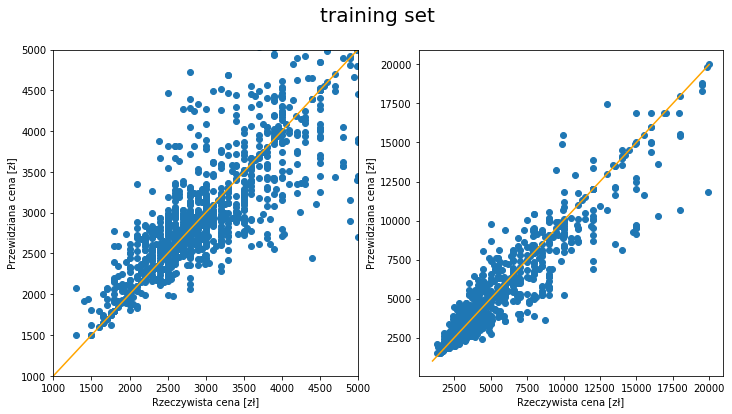

In [77]:
fig = plt.figure(figsize=(12,6))
y_pred_train = regressor.predict(x_train)

fig.add_subplot(1,2,1)
plt.scatter(y_train, y_pred_train)
plt.plot([1000, 20000], [1000, 20000], color='orange')
plt.xlabel('Rzeczywista cena [zł]')
plt.ylabel('Przewidziana cena [zł]')
plt.xlim(1000, 5000)
plt.ylim(1000, 5000)

fig.add_subplot(1,2,2)
plt.scatter(y_train, y_pred_train)
plt.plot([1000, 20000], [1000, 20000], color='orange')
plt.xlabel('Rzeczywista cena [zł]')
plt.ylabel('Przewidziana cena [zł]')
fig.suptitle('training set', fontsize=20)

mse = np.sqrt(mean_squared_error(y_true=y_train, y_pred=y_pred_train))
r2 = r2_score(y_train, y_pred_train)
print("Mean square error is {}\nR^2 score is {}".format(mse, r2))

## 4.5. b) Calculate error on test set

Mean square error is 1145.048453857711
R^2 score is 0.8691764613388331


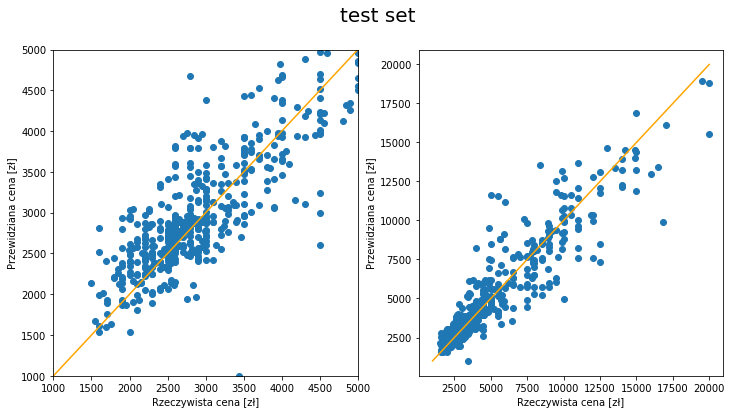

In [78]:
fig = plt.figure(figsize=(12,6))
y_pred_test = regressor.predict(x_test)

fig.add_subplot(1,2,1)
plt.scatter(y_test, y_pred_test)
plt.plot([1000, 20000], [1000, 20000], color='orange')
plt.xlabel('Rzeczywista cena [zł]')
plt.ylabel('Przewidziana cena [zł]')
plt.xlim(1000, 5000)
plt.ylim(1000, 5000)

fig.add_subplot(1,2,2)
plt.scatter(y_test, y_pred_test)
plt.plot([1000, 20000], [1000, 20000], color='orange')
plt.xlabel('Rzeczywista cena [zł]')
plt.ylabel('Przewidziana cena [zł]')
fig.suptitle('test set', fontsize=20)

mse = np.sqrt(mean_squared_error(y_true=y_test, y_pred=y_pred_test))
r2 = r2_score(y_test, y_pred_test)
print("Mean square error is {}\nR^2 score is {}".format(mse, r2))

## 4.6. Analyse of error in regression approach

,train error,test error
count,1537.000000,659.000000
mean,0.970669,4.524689
std,17.188433,21.079419
min,-58.461321,-71.102353
25%,-7.614916,-7.297546
50%,0.000497,1.859938
75%,8.197193,12.660364
max,95.306889,133.253222


Text(0.5, 0, 'relative error [%]')

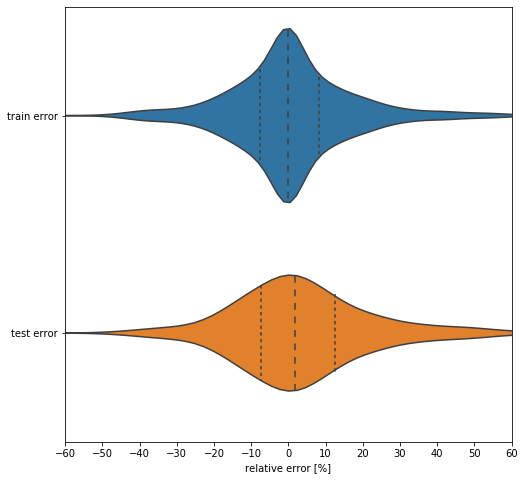

In [79]:
# For all predicted values measure relative difference from exact value and analyse that distribution

train_error = [100*(y_pred_train[i] - float(y_train.iloc[i])) / float(y_train.iloc[i]) for i in range(len(y_train))]
test_error = [100*(y_pred_test[i] - float(y_test.iloc[i])) / float(y_test.iloc[i]) for i in range(len(y_test))]

error_df = pd.DataFrame([train_error, test_error]).T.rename(columns={0:'train error', 1:'test error'})
display(error_df.describe())


plt.figure(figsize=(8,8))
sns.violinplot(data=error_df, inner='quartile', orient='h')
plt.xlim(-50,50)
plt.xticks(np.arange(-60, 65, 10))
plt.xlabel('relative error [%]')

## Comment:

`50% of data` in training set has relative error in range `(-8%, 7%)`, what means about `7.5% relative error` for half of the training set.

Similarly, `50% of data` in test set has relative error inside range `(-8.5%, 13.5%)`, which is `11% relative error` on average.

**For example:** if we have a sample `out of training set` of apartament that has price `2500 zł in advertisement`, this algorithm has `50% chance` to predict price in range `(2288 zł, 2837 zł)`.

## 4.7. Test on some hand-typed data

In [80]:
test = pd.DataFrame([[45, 2, 52.197751, 20.964537, 2018, 25]], columns=['Powierzchnia', 'Liczba pokoi', 'φ', 'λ', 'Rok budowy', 'Czas dojazdu do centrum'])
test_ = scaler_x.transform(test)
display(test)

print("For an apartment with area = {} m^2, {} room(s), build in {} and located at ({}, {}), predicted price is {} zł.".
      format(test['Powierzchnia'].iloc[0], test['Liczba pokoi'].iloc[0], test['Rok budowy'].iloc[0]
             , test['φ'].iloc[0], test['λ'].iloc[0], round(regressor.predict(test_)[0])))

,Powierzchnia,Liczba pokoi,φ,λ,Rok budowy,Czas dojazdu do centrum
0,45,2,52.197751,20.964537,2018,25


For an apartment with area = 45 m^2, 2 room(s), build in 2018 and located at (52.197751, 20.964537), predicted price is 3052.0 zł.


## Comment:
True price for entered apartament is `3300 zł`, so the relative error is `-10.6%`.

## 4.8. Dump learned model to pickle files

In [81]:
if not os.path.isdir("../predict_price/pickles"):
     os.mkdir("../predict_price/pickles")

with open('../predict_price/pickles/predict_rental_price.pkl', 'wb') as f:
    pickle.dump(regressor, f)
    
with open('../predict_price/pickles/predict_rental_price_scaler.pkl', 'wb') as f:
    pickle.dump(scaler_x, f)